## Binary classification with Logistic regression 

### import libraries 

In [2]:
from sqlalchemy import create_engine 
import pymysql 
import getpass #hidden password
password= getpass.getpass()

········


In [3]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

### connection to sql 

In [4]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [5]:
df= pd.read_sql_query('''select t.type, t.operation, t.amount as t_amount, t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status from trans t
left join loan l
on t.account_id = l.account_id
where l.status in ('A', 'B')''', engine)


In [6]:
df.head()

type      operation  t_amount  balance k_symbol  l_amount  duration  \
0  PRIJEM  PREVOD Z UCTU   44749.0  45549.0              79608        24   
1  PRIJEM          VKLAD    1000.0   1000.0              52788        12   
2  PRIJEM          VKLAD    1100.0   1100.0              21924        36   
3  PRIJEM          VKLAD     700.0    700.0              23052        12   
4  PRIJEM          VKLAD     900.0    900.0              41904        12   

   payments status  
0    3317.0      A  
1    4399.0      A  
2     609.0      A  
3    1921.0      A  
4    3492.0      A

### EDA - exploratory data analysis - get to know the data 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  int64  
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 5.1+ MB


In [8]:
# i want to see the means etc 
df.describe()

t_amount        balance       l_amount      duration      payments
count  74364.000000   74364.000000   74364.000000  74364.000000  74364.000000
mean    7832.649125   46022.153061  102745.132645     23.942230   4356.580832
std    11729.040391   25439.948570   74749.275498     12.155783   2205.840892
min        0.000000  -14137.200000    4980.000000     12.000000    319.000000
25%      144.300000   27675.125000   46320.000000     12.000000   2569.000000
50%     3000.000000   40965.150000   86184.000000     24.000000   4051.000000
75%     9868.500000   60098.550000  140400.000000     36.000000   6315.000000
max    87300.000000  193910.000000  464520.000000     60.000000   9736.000000

In [9]:
# i want to understand the data types 
df.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration       int64
payments     float64
status        object
dtype: object

In [10]:
df.shape

(74364, 9)

In [11]:
# clean /wrangling steps :
# change duration to object type / categorical - 12,24,36,48,72  
#k symbol includes ' ' white spaces - deal with those (and operation)
# drop any columns ? if columns are same, have too many nulls, dont add anything  -- iterative


#histograms or boxplots
# split the data into num and cat --- > diff options cleaning / scaling 

# check for multicollinearity 


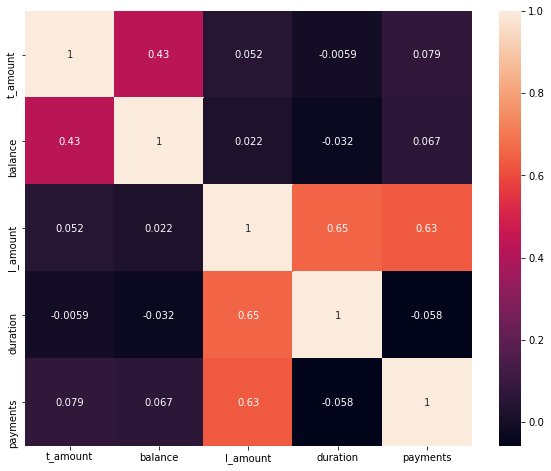

In [12]:
# check for multicollinearity 
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

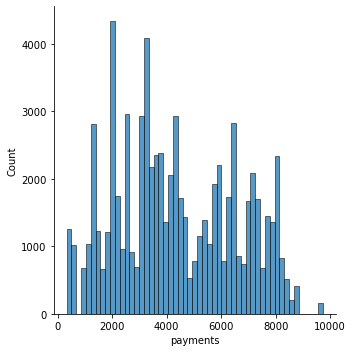

In [13]:
sns.displot(df['payments'])
plt.show()

Frequency analysis of column:  type
Frequency analysis of column:  operation
Frequency analysis of column:  k_symbol
Frequency analysis of column:  status


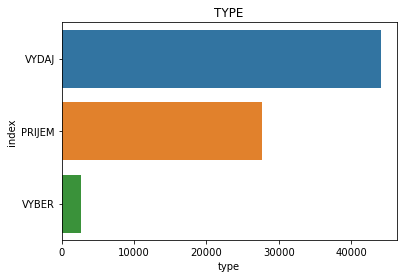

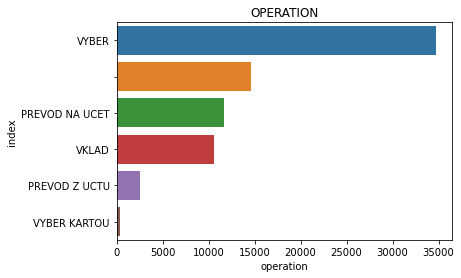

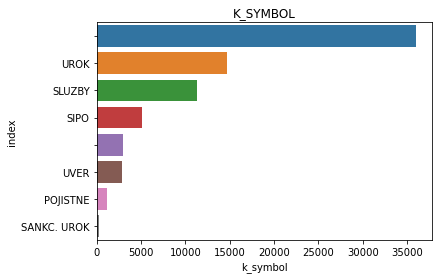

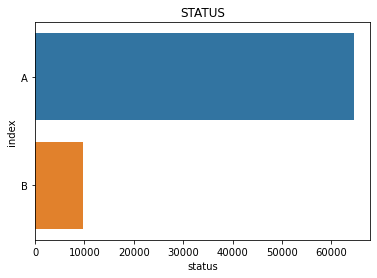

<Figure size 432x288 with 0 Axes>

In [14]:
## checking all the categorical columns
cols_cat = list(df.select_dtypes(include=['object']).columns)

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = df[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print

### Clean and wrangling steps 

In [15]:
# change duration to object type 
#df['duration']=df['duration'].astype('str')
df['duration']=df['duration'].astype('object')

In [16]:
df.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration      object
payments     float64
status        object
dtype: object

In [17]:
df['k_symbol'].value_counts()

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [18]:
def cleankSymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

df['k_symbol'] = list(map(cleankSymbol, df['k_symbol']))

In [19]:
df['operation'].value_counts()

VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64

In [20]:
def cleanOperation(x):
    x = x.lower()
    if 'vyber' in x:
        return "vyber"
    elif 'prevod' in x:
        return "prevod"
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

df['operation'] = list(map(cleanOperation, df['operation']))

### pre processing 

In [21]:
# label / encode any categorical columns 

cat = df.select_dtypes(include = np.object)
cat

type operation k_symbol duration status
0      PRIJEM    prevod  unknown       24      A
1      PRIJEM     vklad  unknown       12      A
2      PRIJEM     vklad  unknown       36      A
3      PRIJEM     vklad  unknown       12      A
4      PRIJEM     vklad  unknown       12      A
...       ...       ...      ...      ...    ...
74359  PRIJEM   unknown     UROK       36      A
74360  PRIJEM   unknown     UROK       24      B
74361  PRIJEM   unknown     UROK       36      A
74362  PRIJEM   unknown     UROK       60      A
74363  PRIJEM   unknown     UROK       24      A

[74364 rows x 5 columns]

In [22]:
categorical=pd.get_dummies(cat, columns =['type', 'operation','k_symbol','duration', 'status'],drop_first=True)
categorical.head()
# could choose or not choose to drop first column 

type_VYBER  type_VYDAJ  operation_unknown  operation_vklad  \
0           0           0                  0                0   
1           0           0                  0                1   
2           0           0                  0                1   
3           0           0                  0                1   
4           0           0                  0                1   

   operation_vyber  k_symbol_SANKC. UROK  k_symbol_SIPO  k_symbol_SLUZBY  \
0                0                     0              0                0   
1                0                     0              0                0   
2                0                     0              0                0   
3                0                     0              0                0   
4                0                     0              0                0   

   k_symbol_UROK  k_symbol_UVER  k_symbol_unknown  duration_24  duration_36  \
0              0              0                 1            1            0   
1              0              0                 1            0            0   
2              0              0                 1            0            1   
3              0              0                 1            0            0   
4              0              0                 1            0            0   

   duration_48  duration_60  status_B  
0            0            0         0  
1            0            0         0  
2            0            0         0  
3            0            0         0  
4            0            0         0

In [23]:
categorical['status_B'].value_counts()

0    64599
1     9765
Name: status_B, dtype: int64

In [24]:
# numerical scaling 

from sklearn.preprocessing import Normalizer

In [25]:
X = df.select_dtypes(include=np.number)
transformer = Normalizer().fit(X)
X_normalised= transformer.transform(X)
X_normalised = pd.DataFrame(X_normalised)

### split off the dependant variable (label)

In [26]:
#sort out the categoricals 
y= categorical['status_B']
categorical=categorical.drop(['status_B'], axis=1)
categorical

type_VYBER  type_VYDAJ  operation_unknown  operation_vklad  \
0               0           0                  0                0   
1               0           0                  0                1   
2               0           0                  0                1   
3               0           0                  0                1   
4               0           0                  0                1   
...           ...         ...                ...              ...   
74359           0           0                  1                0   
74360           0           0                  1                0   
74361           0           0                  1                0   
74362           0           0                  1                0   
74363           0           0                  1                0   

       operation_vyber  k_symbol_SANKC. UROK  k_symbol_SIPO  k_symbol_SLUZBY  \
0                    0                     0              0                0   
1                    0                     0              0                0   
2                    0                     0              0                0   
3                    0                     0              0                0   
4                    0                     0              0                0   
...                ...                   ...            ...              ...   
74359                0                     0              0                0   
74360                0                     0              0                0   
74361                0                     0              0                0   
74362                0                     0              0                0   
74363                0                     0              0                0   

       k_symbol_UROK  k_symbol_UVER  k_symbol_unknown  duration_24  \
0                  0              0                 1            1   
1                  0              0                 1            0   
2                  0              0                 1            0   
3                  0              0                 1            0   
4                  0              0                 1            0   
...              ...            ...               ...          ...   
74359              1              0                 0            0   
74360              1              0                 0            1   
74361              1              0                 0            0   
74362              1              0                 0            0   
74363              1              0                 0            1   

       duration_36  duration_48  duration_60  
0                0            0            0  
1                0            0            0  
2                1            0            0  
3                0            0            0  
4                0            0            0  
...            ...          ...          ...  
74359            1            0            0  
74360            0            0            0  
74361            1            0            0  
74362            0            0            1  
74363            0            0            0  

[74364 rows x 15 columns]

In [27]:
# bring the numerical data (scaled)in with the x cat
X = np.concatenate((X_normalised, categorical),axis=1)

### tt split, get model

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size= 0.4, random_state=40)

## apply model and train model 

In [30]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

### evaluate accuracy and test 

In [31]:
from sklearn.metrics import accuracy_score 
predictions = classification.predict(X_test)

In [32]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [33]:
accuracy_score(y_test, predictions)

0.87591608955826

In [34]:
# next steps would be to visualise the accuracy of the predictions in some ways 

# can i improve my model ?? 

### visualising accuracy - ROC / AUC 

In [35]:
import sklearn.metrics as metrics 
probs = classification.predict_proba(X_test)
preds =probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7669225271641318


In [36]:
#definitions 
# tpr = true positive rate 
# fpr = false positive rate

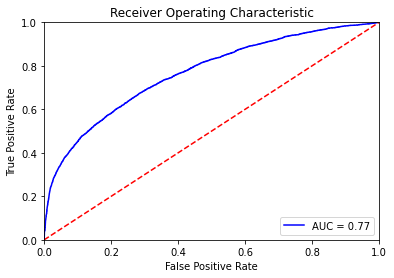

In [37]:
# method to plot AUC visually 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

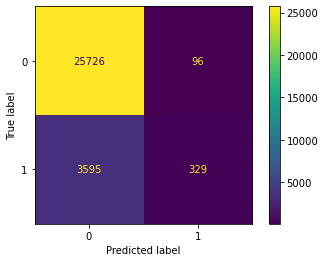

In [38]:
# confusion matrix 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix

accuracy_score(y_test,predictions)
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()



### data imbalanced - resolve 

In [49]:
y.value_counts()

0    64599
1     9765
Name: status_B, dtype: int64

In [39]:
# use SMOTE technique It2 
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [40]:
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

0    64599
1    64599
Name: status_B, dtype: int64

In [41]:
#re do train test split It2

X_train, X_test, y_train, y_test =train_test_split(X_sm, y_sm, test_size= 0.4, random_state=40)

In [42]:
# apply model It2 
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

In [43]:
#accuracy assessment It2
predictions = classification.predict(X_test)
accuracy_score(y_test, predictions)

0.6912732198142415

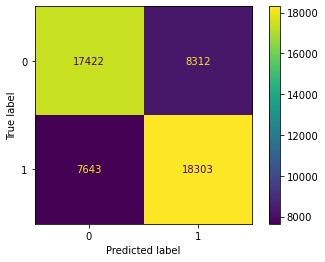

In [44]:
#Conf matrix It2 
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()

In [48]:
#Tomek links It3 - warning this is going to be quite slow as its a heavy algorithm
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_resample(X, y)
y_tl.value_counts()
# as you can see no new data is created for the minority class
#but some majority class data points are dropped 



0    61140
1     9765
Name: status_B, dtype: int64

In [50]:
#re do train test split It3

X_train, X_test, y_train, y_test =train_test_split(X_tl, y_tl, test_size= 0.4, random_state=40)

In [51]:
# apply model It3
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

In [52]:
#accuracy assessment It3
predictions = classification.predict(X_test)
accuracy_score(y_test, predictions)

0.8736337352795994

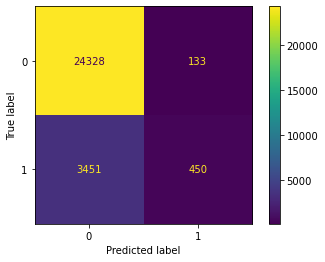

In [53]:
#Conf matrix It3 
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()

### conclusion on imbalance:
- The SMOTE or TOMEK LINKs techniques alone are not effective in making the model more accurate
- I could of course try for a hybrid approach of sampling methods 
https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/
    
- I would actually rather next turn to feature engineering and feature selection 
